In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_path = 'data/I88N-processed/'

# Initialization

## Sample dates, split train/test dataset

In [3]:
dates = pd.read_csv(base_path + 'available_dates.csv')
dates = np.array(dates['0'].values.tolist())
dates = np.array(list(map(lambda x: x.split('-')[1] + '/' + x.split('-')[2] + '/' + x.split('-')[0], dates)))

We want to sample dates in May and June for testing.

In [4]:
dates = dates[(dates > '06/30/2017') & (dates < '10/01/2017')]

In [5]:
dates_train = np.random.choice(dates, 45, replace=True)
dates_train.sort()
dates_test = np.array(sorted(set(dates).difference(set(dates_train.tolist()))))

In [6]:
len(dates), len(dates_train), len(dates_test), dates_train[0:3], dates_test[0:3]

(84,
 45,
 48,
 array(['07/11/2017', '07/12/2017', '07/13/2017'], dtype='<U10'),
 array(['07/02/2017', '07/03/2017', '07/05/2017'], dtype='<U10'))

## Loading speed, flow, occupancy, and stations

In [7]:
raw = pd.read_csv(base_path + 'concat_no_holes/concat.csv')

In [8]:
# select raw that is sampled
raw_all = raw.loc[raw['Date'].isin(dates)]
raw_test = raw_all.loc[raw['Date'].isin(dates_test)]

In [9]:
# special construction of raw_train, because the dates are sampled with replacement
raw_train = raw.loc[raw['Date'] == dates_train[0]]
for i in range(1, len(dates_train)):
    raw_train = raw_train.append(raw.loc[raw['Date'] == dates_train[i]])

In [10]:
len(raw_train.index)

1321920

In [11]:
stations = np.array(raw_all['Station ID'].unique().tolist())

In [12]:
var_names = ['Speed', 'Flow', 'Occupancy']

### Construct road segments

In [13]:
road_segments = list()
for i in range(len(stations) - 1):
    road_segments.append(tuple([stations[i], stations[i+1]]))

## Loading incidents

In [14]:
raw_incidents = pd.read_csv(base_path + 'valid_incidents.csv')

In [15]:
raw_incidents_all = raw_incidents.loc[raw_incidents['Date'].isin(dates)]
raw_incidents_train = raw_incidents_all.loc[raw_incidents_all['Date'].isin(dates_train)]
raw_incidents_test = raw_incidents_all.loc[raw_incidents_all['Date'].isin(dates_test)]

In [16]:
svm_pos_timestamps = pd.read_csv(base_path + 'svm_pos_instances.csv')

In [17]:
svm_pos_timestamps_train = svm_pos_timestamps.loc[svm_pos_timestamps['Date'].isin(dates_train)]
svm_pos_timestamps_test = svm_pos_timestamps.loc[svm_pos_timestamps['Date'].isin(dates_test)]

In [18]:
svm_pos_timestamps.head(3)

,Upstream,Downstream,Date,Time
0,408907,400951,01/22/2017,20:30
1,408907,400951,01/22/2017,20:35
2,408907,400951,01/22/2017,20:40


In [19]:
svm_incident_dates_train = svm_pos_timestamps_train['Date'].unique().tolist()
svm_normal_dates_train = list(set(dates_train).difference(svm_incident_dates_train))

In [20]:
len(svm_incident_dates_train), len(svm_normal_dates_train)

(36, 0)

## Progress message formatting

In [21]:
def fraction_msg(present, total):
    return '[{}/{}]'.format(present, total)

# Train: TSA-DES forecasting

In [22]:
def DES_rmse(alpha, var_series):
    len_series = len(var_series)
    
    beta = round(1. - alpha, 3)

    sse = 0.
    s1 = np.mean(var_series[:10])
    s2 = s1
    
    for i in range(11, len_series - 1):
        s1 = alpha * var_series[i] + beta * s1
        s2 = alpha * s1 + beta * s2
        y_next = 2 * s1 - s2 + alpha / beta * (s1 - s2)
        sse += (var_series[i+1] - y_next) ** 2
    
    return np.sqrt( sse / (len_series - 12) )

## Tune best alphas for each station

In [23]:
best_alphas = {
    'Station ID': [],
    'Speed': [],
    'Flow': [],
    'Occupancy': []
}
num_grids = 100
for i, station in enumerate(stations):
    best_alphas['Station ID'].append(station)
    
    # update current training station dataframe, the training data is normal day's data
    abnormal_dates_station = raw_incidents_train.loc[(raw_incidents_train['Upstream'] == station) | (raw_incidents_train['Downstream'] == str(station))]['Date'].unique()
    normal_dates_train = np.array(list(set(dates_train).difference(set(abnormal_dates_station))))
    df_train_station = raw_train.loc[(raw_train['Station ID'] == station) & (raw_train['Date'].isin(normal_dates_train))]

    print(fraction_msg(i+1, len(stations)) + " Tuning alphas for station " + str(station) + "...")
    for var_name in var_names:
        print("    " + var_name + "...")
        var_series = df_train_station[var_name].values
        len_series = len(var_series)
        
        # setting up alphas
        alphas = np.arange(num_grids) * 1. / num_grids
        
        # save the historical best alpha by rmse
        best_rmse = float("inf")
        best_alpha = 0.
        
        # for each alpha, perform exponential smoothing, and compute RMSE
        for alpha in alphas:
            rmse = DES_rmse(alpha, var_series)
            
            # compare, and decide whether to update best alpha
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
        
        # finally, save the best alpha for the variable at this station
        best_alphas[var_name].append(best_alpha)
    
    # print trained alphas for each station
    print(best_alphas['Station ID'][i], best_alphas['Speed'][i], best_alphas['Flow'][i], best_alphas['Occupancy'][i])

[1/102] Tuning alphas for station 408907...
    Speed...
    Flow...
    Occupancy...
408907 0.65 0.18 0.41
[2/102] Tuning alphas for station 400951...
    Speed...
    Flow...
    Occupancy...
400951 0.65 0.2 0.46
[3/102] Tuning alphas for station 400057...
    Speed...
    Flow...
    Occupancy...
400057 0.74 0.21 0.43
[4/102] Tuning alphas for station 400147...
    Speed...
    Flow...
    Occupancy...
400147 0.7 0.23 0.42
[5/102] Tuning alphas for station 400343...
    Speed...
    Flow...
    Occupancy...
400343 0.6 0.23 0.29
[6/102] Tuning alphas for station 401560...
    Speed...
    Flow...
    Occupancy...
401560 0.55 0.19 0.2
[7/102] Tuning alphas for station 400045...
    Speed...
    Flow...
    Occupancy...
400045 0.65 0.24 0.39
[8/102] Tuning alphas for station 400122...
    Speed...
    Flow...
    Occupancy...
400122 0.72 0.25 0.43
[9/102] Tuning alphas for station 401541...
    Speed...
    Flow...
    Occupancy...
401541 0.66 0.24 0.32
[10/102] Tuning alphas for stati

    Flow...
    Occupancy...
400574 0.54 0.22 0.36
[77/102] Tuning alphas for station 401629...
    Speed...
    Flow...
    Occupancy...
401629 0.6 0.29 0.4
[78/102] Tuning alphas for station 400422...
    Speed...
    Flow...
    Occupancy...
400422 0.66 0.21 0.44
[79/102] Tuning alphas for station 400333...
    Speed...
    Flow...
    Occupancy...
400333 0.59 0.13 0.28
[80/102] Tuning alphas for station 410363...
    Speed...
    Flow...
    Occupancy...
410363 0.36 0.12 0.18
[81/102] Tuning alphas for station 400360...
    Speed...
    Flow...
    Occupancy...
400360 0.57 0.21 0.31
[82/102] Tuning alphas for station 400955...
    Speed...
    Flow...
    Occupancy...
400955 0.59 0.22 0.44
[83/102] Tuning alphas for station 400495...
    Speed...
    Flow...
    Occupancy...
400495 0.56 0.2 0.37
[84/102] Tuning alphas for station 400608...
    Speed...
    Flow...
    Occupancy...
400608 0.71 0.23 0.43
[85/102] Tuning alphas for station 400949...
    Speed...
    Flow...
    Occupa

In [24]:
best_alphas_df = pd.DataFrame(best_alphas)
best_alphas_df.to_csv(base_path + 'smaller_sample/best_alphas.csv', index=False)

## Using the tuned alphas to predict training traffic variables

In [25]:
# initialization
# initialize prediction dictionary
pred_dict_train = dict()
for var_name in var_names:
    pred_dict_train[var_name] = []

for i, station in enumerate(stations):
    print("{} Start time series prediction (DES) at station {}...".format(fraction_msg(i+1, len(stations)), station))
    df_train_station = raw_train.loc[raw_train["Station ID"] == station]
    
    # formulate predictions of speed, flow and occupancy for the station
    for var_name in var_names:
        print("    {}...".format(var_name))
        var_series = df_train_station[var_name].values
        len_series = len(var_series)
        # initialize s1, s2, and y
        s1 = np.mean(var_series[:10])
        s2 = s1
        y = [0.] * len_series
        # get the best alpha
        var_best_alpha = best_alphas_df.loc[best_alphas_df["Station ID"] == station][var_name].values[0]
        beta = 1. - var_best_alpha

        for t in range(11, len_series - 1):
            s1 = var_best_alpha * var_series[t] + beta * s1
            s2 = var_best_alpha * s1 + beta * s2
            y[t+1] = round(2 * s1 - s2 + alpha / beta * (s1 - s2), 2)

        # save the predictions to a dictionary
        pred_dict_train[var_name].extend(y)
    print("End prediction at station {}.".format(station))

[1/102] Start time series prediction (DES) at station 408907...
    Speed...
    Flow...
    Occupancy...
End prediction at station 408907.
[2/102] Start time series prediction (DES) at station 400951...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400951.
[3/102] Start time series prediction (DES) at station 400057...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400057.
[4/102] Start time series prediction (DES) at station 400147...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400147.
[5/102] Start time series prediction (DES) at station 400343...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400343.
[6/102] Start time series prediction (DES) at station 401560...
    Speed...
    Flow...
    Occupancy...
End prediction at station 401560.
[7/102] Start time series prediction (DES) at station 400045...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400045.
[8/102] Start time s

    Occupancy...
End prediction at station 417665.
[60/102] Start time series prediction (DES) at station 412637...
    Speed...
    Flow...
    Occupancy...
End prediction at station 412637.
[61/102] Start time series prediction (DES) at station 417666...
    Speed...
    Flow...
    Occupancy...
End prediction at station 417666.
[62/102] Start time series prediction (DES) at station 408134...
    Speed...
    Flow...
    Occupancy...
End prediction at station 408134.
[63/102] Start time series prediction (DES) at station 400685...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400685.
[64/102] Start time series prediction (DES) at station 401003...
    Speed...
    Flow...
    Occupancy...
End prediction at station 401003.
[65/102] Start time series prediction (DES) at station 400898...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400898.
[66/102] Start time series prediction (DES) at station 400275...
    Speed...
    Flow...
    Occupancy

In [26]:
raw_train = raw_train.assign(Pred_Speed=pred_dict_train['Speed'], Pred_Flow=pred_dict_train['Flow'], Pred_Occupancy=pred_dict_train['Occupancy'])

## Using the tuned alphas to predict testing traffic variables

In [27]:
# initialization
# initialize prediction dictionary
pred_dict_test = dict()
for var_name in var_names:
    pred_dict_test[var_name] = []

for i, station in enumerate(stations):
    print("{} Start time series prediction (DES) at station {}...".format(fraction_msg(i+1, len(stations)), station))
    df_test_station = raw_test.loc[raw_test["Station ID"] == station]
    
    # formulate predictions of speed, flow and occupancy for the station
    for var_name in var_names:
        print("    {}...".format(var_name))
        var_series = df_test_station[var_name].values
        len_series = len(var_series)
        # initialize s1, s2, and y
        s1 = np.mean(var_series[:10])
        s2 = s1
        y = [0.] * len_series
        # get the best alpha
        var_best_alpha = best_alphas_df.loc[best_alphas_df["Station ID"] == station][var_name].values[0]
        beta = 1. - var_best_alpha

        for t in range(11, len_series - 1):
            s1 = var_best_alpha * var_series[t] + beta * s1
            s2 = var_best_alpha * s1 + beta * s2
            y[t+1] = round(2 * s1 - s2 + alpha / beta * (s1 - s2), 2)

        # save the predictions to a dictionary
        pred_dict_test[var_name].extend(y)
    print("Finished forecasting at station {}.".format(station))
print("Finished forecasting for the test dataset.")

[1/102] Start time series prediction (DES) at station 408907...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 408907.
[2/102] Start time series prediction (DES) at station 400951...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400951.
[3/102] Start time series prediction (DES) at station 400057...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400057.
[4/102] Start time series prediction (DES) at station 400147...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400147.
[5/102] Start time series prediction (DES) at station 400343...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400343.
[6/102] Start time series prediction (DES) at station 401560...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 401560.
[7/102] Start time series prediction (DES) at station 400045...
    Speed...
    Flow...
    Occupancy...
Finished forecasti

    Occupancy...
Finished forecasting at station 408133.
[58/102] Start time series prediction (DES) at station 408135...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 408135.
[59/102] Start time series prediction (DES) at station 417665...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 417665.
[60/102] Start time series prediction (DES) at station 412637...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 412637.
[61/102] Start time series prediction (DES) at station 417666...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 417666.
[62/102] Start time series prediction (DES) at station 408134...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 408134.
[63/102] Start time series prediction (DES) at station 400685...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400685.
[64/102] Start time series prediction (DES) at station 401003

In [28]:
raw_test = raw_test.assign(Pred_Speed=pred_dict_test['Speed'], Pred_Flow=pred_dict_test['Flow'], Pred_Occupancy=pred_dict_test['Occupancy'])

In [29]:
raw_test.tail(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx,Pred_Speed,Pred_Flow,Pred_Occupancy
6556605,401471,2017-09-29 23:45:00,3.6,177.0,60.0,09/29/2017,23:45,3227659,59.10,191.26,4.02
6556606,401471,2017-09-29 23:50:00,3.7,175.0,59.5,09/29/2017,23:50,3227660,59.36,178.88,3.73
6556607,401471,2017-09-29 23:55:00,4.4,236.0,60.6,09/29/2017,23:55,3227661,59.07,169.34,3.62


# Train: SVM

In [30]:
import datetime as dt

Note that we need to scale train and test dataset with the same factors.

## Train: feature vectors

### Train: feature vectors - negative

In [31]:
neg_times = raw_train['Time'].unique().tolist()[14:]

In [32]:
neg_sample_dates = np.random.choice(dates_train, 14, replace=False)

In [34]:
svm_incidents_sample = svm_pos_timestamps_train.loc[svm_pos_timestamps_train['Date'].isin(neg_sample_dates)]

In [35]:
X_neg_train = []
num_segments = len(road_segments)
count_date = 0
for neg_sample_date in neg_sample_dates:
    count_date += 1
    print("{} Negative feature vectors at date {}:".format(fraction_msg(count_date, len(neg_sample_dates)), neg_sample_date))
    
    for i, seg in enumerate(road_segments):
        B, E = seg
        df_neg_train_BE = raw_train.loc[((raw_train["Station ID"] == B) | (raw_train["Station ID"] == E)) & (raw_train["Date"] == neg_sample_date)]
        svm_incidents_sample_BE = svm_incidents_sample.loc[svm_incidents_sample['Upstream'] == B]
        sample_neg_times = np.random.choice(neg_times, 24)
        
        if (i+1) % 20 == 0:
            print("    {} Start constructing feature vectors for road segment s_{},{}...".format(fraction_msg(i+1, num_segments), B, E))
            print("        Total number of vectors: {}".format(len(sample_neg_times)))
        
        for neg_t in sample_neg_times:
            # check if current time is incident time
            if len(svm_incidents_sample_BE.loc[svm_incidents_sample_BE['Time'] == neg_t].index) != 0:
                continue

            feature_t = []
            neg_dt_timestamp = pd.Timestamp(neg_sample_date + ' ' + neg_t + ':00')

            B_lags = []
            for j in range(5):
                B_lags.append(neg_dt_timestamp - dt.timedelta(minutes=j*5))
            B_lags = list(map(lambda x: x.strftime('%H:%M') , B_lags))
            E_lags = B_lags[0:3]

            # upstream features
            for t_lag in B_lags:
                df_dt_lag = df_neg_train_BE.loc[(df_neg_train_BE["Station ID"] == B) & (df_neg_train_BE["Time"] == t_lag)]

                speed_B_t = df_dt_lag["Speed"].values[0]
                flow_B_t = df_dt_lag["Flow"].values[0]
                occ_B_t = df_dt_lag["Occupancy"].values[0]

                speed_pred_B_t = df_dt_lag["Pred_Speed"].values[0]
                flow_pred_B_t = df_dt_lag["Pred_Flow"].values[0]
                occ_pred_B_t = df_dt_lag["Pred_Occupancy"].values[0]

                feature_t.extend([speed_B_t, flow_B_t, occ_B_t, speed_pred_B_t, flow_pred_B_t, occ_pred_B_t, speed_B_t - speed_pred_B_t, flow_B_t - flow_pred_B_t, occ_B_t - occ_pred_B_t])

            # downstream features
            for t_lag in E_lags:
                df_dt_lag = df_neg_train_BE.loc[(df_neg_train_BE["Station ID"] == E) & (df_neg_train_BE["Time"] == t_lag)]

                speed_E_t = df_dt_lag["Speed"].values[0]
                flow_E_t = df_dt_lag["Flow"].values[0]
                occ_E_t = df_dt_lag["Occupancy"].values[0]

                speed_pred_E_t = df_dt_lag["Pred_Speed"].values[0]
                flow_pred_E_t = df_dt_lag["Pred_Flow"].values[0]
                occ_pred_E_t = df_dt_lag["Pred_Occupancy"].values[0]

                feature_t.extend([speed_E_t, flow_E_t, occ_E_t, speed_pred_E_t, flow_pred_E_t, occ_pred_E_t, speed_E_t - speed_pred_E_t, flow_E_t - flow_pred_E_t, occ_E_t - occ_pred_E_t])
            X_neg_train.append(feature_t)

        if (i+1) % 20 == 0:
            print("        Feature vector at date and time {} {} is done.".format(neg_sample_date, neg_t))
            print("    ...Completed construction of feature vectors for road segment s_{},{}.".format(B, E))

[1/14] Negative feature vectors at date 08/06/2017:
    [20/101] Start constructing feature vectors for road segment s_402290,402292...
        Total number of vectors: 24
        Feature vector at date and time 08/06/2017 03:25 is done.
    ...Completed construction of feature vectors for road segment s_402290,402292.
    [40/101] Start constructing feature vectors for road segment s_400137,400716...
        Total number of vectors: 24
        Feature vector at date and time 08/06/2017 16:55 is done.
    ...Completed construction of feature vectors for road segment s_400137,400716.
    [60/101] Start constructing feature vectors for road segment s_412637,417666...
        Total number of vectors: 24
        Feature vector at date and time 08/06/2017 09:00 is done.
    ...Completed construction of feature vectors for road segment s_412637,417666.
    [80/101] Start constructing feature vectors for road segment s_410363,400360...
        Total number of vectors: 24
        Feature vecto

[7/14] Negative feature vectors at date 07/22/2017:
    [20/101] Start constructing feature vectors for road segment s_402290,402292...
        Total number of vectors: 24
        Feature vector at date and time 07/22/2017 14:20 is done.
    ...Completed construction of feature vectors for road segment s_402290,402292.
    [40/101] Start constructing feature vectors for road segment s_400137,400716...
        Total number of vectors: 24
        Feature vector at date and time 07/22/2017 22:50 is done.
    ...Completed construction of feature vectors for road segment s_400137,400716.
    [60/101] Start constructing feature vectors for road segment s_412637,417666...
        Total number of vectors: 24
        Feature vector at date and time 07/22/2017 09:10 is done.
    ...Completed construction of feature vectors for road segment s_412637,417666.
    [80/101] Start constructing feature vectors for road segment s_410363,400360...
        Total number of vectors: 24
        Feature vecto

[13/14] Negative feature vectors at date 08/17/2017:
    [20/101] Start constructing feature vectors for road segment s_402290,402292...
        Total number of vectors: 24
        Feature vector at date and time 08/17/2017 10:45 is done.
    ...Completed construction of feature vectors for road segment s_402290,402292.
    [40/101] Start constructing feature vectors for road segment s_400137,400716...
        Total number of vectors: 24
        Feature vector at date and time 08/17/2017 17:00 is done.
    ...Completed construction of feature vectors for road segment s_400137,400716.
    [60/101] Start constructing feature vectors for road segment s_412637,417666...
        Total number of vectors: 24
        Feature vector at date and time 08/17/2017 16:20 is done.
    ...Completed construction of feature vectors for road segment s_412637,417666.
    [80/101] Start constructing feature vectors for road segment s_410363,400360...
        Total number of vectors: 24
        Feature vect

In [36]:
len(X_neg_train)

32341

In [37]:
y_neg_train = [-1] * len(X_neg_train)

### Train: feature vectors - positive

In [38]:
working_time = raw_train['Time'].unique().tolist()[14:]

In [39]:
svm_pos_timestamps_train = svm_pos_timestamps_train.loc[svm_pos_timestamps_train['Time'].isin(working_time)]

In [40]:
X_pos_train = []
for i, seg in enumerate(road_segments):
    B, E = seg
    print("{} Start constructing positive feature vectors for road segment s_{},{}... ".format(fraction_msg(i+1, len(road_segments)), B, E))
    progress_count = 0
    
    # construct segment-specific pos_times
    pos_times = []
    df_seg_incidents = svm_pos_timestamps_train.loc[svm_pos_timestamps_train["Upstream"] == B]
    seg_dates = df_seg_incidents['Date'].values.tolist()
    seg_times = df_seg_incidents['Time'].values.tolist()
    num_seg_instances = len(seg_dates)
    for i in range(num_seg_instances):
        pos_times.append(tuple([seg_dates[i], seg_times[i]]))
    
    # select the relevant training data for segment B, E 
    df_train_BE = raw_train.loc[(raw_train["Station ID"] == B) | (raw_train["Station ID"] == E)]
    
    
    print("    Total number of vectors: {}".format(num_seg_instances))
    for pos_dt in pos_times:
        pos_d, pos_t = pos_dt
        feature_t = []
        pos_dt_timestamp = pd.Timestamp(pos_d + ' ' + pos_t + ':00')

        # upstream and downstream time lags
        B_lags = []
        for j in range(5):
            B_lags.append(pos_dt_timestamp - dt.timedelta(minutes=j*5))
        B_lags = list(map(lambda x: (x.strftime('%m/%d/%Y'), x.strftime('%H:%M')) , B_lags))
        E_lags = B_lags[0:3]

        # upstream features
        for dt_lag in B_lags:
            d_lag, t_lag = dt_lag
            df_dt_lag = df_train_BE.loc[(df_train_BE["Station ID"] == B) & (df_train_BE["Date"] == d_lag) & (df_train_BE["Time"] == t_lag)]
            if df_dt_lag.empty:
                print(d_lag, t_lag)
            
            speed_B_t = df_dt_lag["Speed"].values[0]
            flow_B_t = df_dt_lag["Flow"].values[0]
            occ_B_t = df_dt_lag["Occupancy"].values[0]

            speed_pred_B_t = df_dt_lag["Pred_Speed"].values[0]
            flow_pred_B_t = df_dt_lag["Pred_Flow"].values[0]
            occ_pred_B_t = df_dt_lag["Pred_Occupancy"].values[0]

            feature_t.extend([speed_B_t, flow_B_t, occ_B_t, speed_pred_B_t, flow_pred_B_t, occ_pred_B_t, speed_B_t - speed_pred_B_t, flow_B_t - flow_pred_B_t, occ_B_t - occ_pred_B_t])

        # downstream features
        for dt_lag in E_lags:
            d_lag, t_lag = dt_lag
            df_dt_lag = df_train_BE.loc[(df_train_BE["Station ID"] == E) & (df_train_BE["Date"] == d_lag) & (df_train_BE["Time"] == t_lag)]

            speed_E_t = df_dt_lag["Speed"].values[0]
            flow_E_t = df_dt_lag["Flow"].values[0]
            occ_E_t = df_dt_lag["Occupancy"].values[0]

            speed_pred_E_t = df_dt_lag["Pred_Speed"].values[0]
            flow_pred_E_t = df_dt_lag["Pred_Flow"].values[0]
            occ_pred_E_t = df_dt_lag["Pred_Occupancy"].values[0]

            feature_t.extend([speed_E_t, flow_E_t, occ_E_t, speed_pred_E_t, flow_pred_E_t, occ_pred_E_t, speed_E_t - speed_pred_E_t, flow_E_t - flow_pred_E_t, occ_E_t - occ_pred_E_t])
        X_pos_train.append(feature_t)
        progress_count += 1
        if progress_count % 100 == 0:
            print("    {} Feature vector at date and time {} {} is done.".format(fraction_msg(progress_count, num_seg_instances), pos_d, pos_t))

print("...Completed construction of feature vectors for road segment s_{},{}.".format(B, E))

[1/101] Start constructing positive feature vectors for road segment s_408907,400951... 
    Total number of vectors: 83
[2/101] Start constructing positive feature vectors for road segment s_400951,400057... 
    Total number of vectors: 38
[3/101] Start constructing positive feature vectors for road segment s_400057,400147... 
    Total number of vectors: 23
[4/101] Start constructing positive feature vectors for road segment s_400147,400343... 
    Total number of vectors: 22
[5/101] Start constructing positive feature vectors for road segment s_400343,401560... 
    Total number of vectors: 42
[6/101] Start constructing positive feature vectors for road segment s_401560,400045... 
    Total number of vectors: 59
[7/101] Start constructing positive feature vectors for road segment s_400045,400122... 
    Total number of vectors: 68
[8/101] Start constructing positive feature vectors for road segment s_400122,401541... 
    Total number of vectors: 2
[9/101] Start constructing positi

[67/101] Start constructing positive feature vectors for road segment s_400939,400180... 
    Total number of vectors: 0
[68/101] Start constructing positive feature vectors for road segment s_400180,400529... 
    Total number of vectors: 0
[69/101] Start constructing positive feature vectors for road segment s_400529,400990... 
    Total number of vectors: 0
[70/101] Start constructing positive feature vectors for road segment s_400990,400515... 
    Total number of vectors: 0
[71/101] Start constructing positive feature vectors for road segment s_400515,400252... 
    Total number of vectors: 204
    [100/204] Feature vector at date and time 09/02/2017 13:25 is done.
    [200/204] Feature vector at date and time 09/30/2017 12:10 is done.
[72/101] Start constructing positive feature vectors for road segment s_400252,400788... 
    Total number of vectors: 114
    [100/114] Feature vector at date and time 09/14/2017 11:40 is done.
[73/101] Start constructing positive feature vectors f

In [41]:
len(X_pos_train)

3873

In [42]:
y_pos_train = [1] * len(X_pos_train)

## Train: Merging feature vectors together

In [43]:
X_neg_train = np.array(X_neg_train)

In [44]:
X_neg_train_balanced = X_neg_train[np.random.choice(len(X_neg_train), len(X_pos_train), replace=False)].tolist()

In [45]:
y_neg_train_balanced = [-1] * len(X_neg_train_balanced)

In [46]:
X_train = X_neg_train_balanced + X_pos_train

In [47]:
y_train = y_neg_train_balanced + y_pos_train

In [48]:
len(X_train), len(y_train)

(7746, 7746)

## Test: feature vectors

In [49]:
raw_test = raw_test.assign(Diff_Speed=lambda x:x['Speed']-x['Pred_Speed'], Diff_Flow=lambda x: x['Flow']-x['Pred_Flow'], Diff_Occupancy=lambda x: x['Occupancy']-x['Pred_Occupancy'])

In [50]:
raw_test.tail(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx,Pred_Speed,Pred_Flow,Pred_Occupancy,Diff_Speed,Diff_Flow,Diff_Occupancy
6556605,401471,2017-09-29 23:45:00,3.6,177.0,60.0,09/29/2017,23:45,3227659,59.10,191.26,4.02,0.90,-14.26,-0.42
6556606,401471,2017-09-29 23:50:00,3.7,175.0,59.5,09/29/2017,23:50,3227660,59.36,178.88,3.73,0.14,-3.88,-0.03
6556607,401471,2017-09-29 23:55:00,4.4,236.0,60.6,09/29/2017,23:55,3227661,59.07,169.34,3.62,1.53,66.66,0.78


In [51]:
feature_names = ['Speed', 'Flow', 'Occupancy', 'Pred_Speed', 'Pred_Flow', 'Pred_Occupancy', 'Diff_Speed', 'Diff_Flow', 'Diff_Occupancy']

In [52]:
X_test = []
y_test = []
for seg_idx, seg in enumerate(road_segments):
    B, E = seg
    print("{} Constructing feature vector for segment s_{},{}...".format(fraction_msg(seg_idx+1, len(road_segments)), B, E))
    df_BE_test = raw_test.loc[((raw_test["Station ID"] == B) | (raw_test["Station ID"] == E))]
    df_incidents_BE_test = svm_pos_timestamps_test.loc[svm_pos_timestamps_test["Upstream"] == B]
    incidents_BE_date = df_incidents_BE_test["Date"].values
    incidents_BE_time = df_incidents_BE_test["Time"].values
    
    incidents_BE_dt = set()
    for i in range(len(incidents_BE_date)):
        incidents_BE_dt.add(incidents_BE_date[i] + ' ' + incidents_BE_time[i])
    
    # change to access by indices, to make program faster
    features_BE_dict = dict()
    features_BE_dict[B] = dict()
    features_BE_dict[E] = dict()
    for feature_name in feature_names:
        features_BE_dict[B][feature_name] = df_BE_test.loc[df_BE_test["Station ID"] == B][feature_name].values.tolist()
        features_BE_dict[E][feature_name] = df_BE_test.loc[df_BE_test["Station ID"] == E][feature_name].values.tolist()
    
    total_count = len(dates_test) * len(neg_times)
    count = 0
    print("    Total number of instances: {}".format(total_count)) 
    
    for i, d in enumerate(dates_test):
        for j, t in enumerate(neg_times):
            # construct vector Z(s_BE, dt)
            feature_BE_t = [0.] * 72
            base_idx = i * 288 + 14 + j
            for k, feature_name in enumerate(feature_names):
                # feature_k_B_t: [t-4, t-3, ..., t] -> need to be reversed and made consistent with order of SVM features. Same to E.
                feature_k_B_t = features_BE_dict[B][feature_name][base_idx-4:base_idx+1]
                feature_k_E_t = features_BE_dict[E][feature_name][base_idx-2:base_idx+1]
                feature_k_B_t.reverse()
                feature_k_E_t.reverse()
                feature_k_BE_t = feature_k_B_t + feature_k_E_t
                feature_BE_t[k:72:9] = feature_k_BE_t
            X_test.append(feature_BE_t)
            # label data
            if d + ' ' + t in incidents_BE_dt:
                y_test.append(1)
            else:
                y_test.append(-1)
        count += 1
        if count % 50 == 0:
            print("    Progress: {}" + fraction_msg(count * len(neg_times), total_count))
    print("...Finished construction for segment s_{},{}.".format(B, E))

[1/101] Constructing feature vector for segment s_408907,400951...
    Total number of instances: 13152
...Finished construction for segment s_408907,400951.
[2/101] Constructing feature vector for segment s_400951,400057...
    Total number of instances: 13152
...Finished construction for segment s_400951,400057.
[3/101] Constructing feature vector for segment s_400057,400147...
    Total number of instances: 13152
...Finished construction for segment s_400057,400147.
[4/101] Constructing feature vector for segment s_400147,400343...
    Total number of instances: 13152
...Finished construction for segment s_400147,400343.
[5/101] Constructing feature vector for segment s_400343,401560...
    Total number of instances: 13152
...Finished construction for segment s_400343,401560.
[6/101] Constructing feature vector for segment s_401560,400045...
    Total number of instances: 13152
...Finished construction for segment s_401560,400045.
[7/101] Constructing feature vector for segment s_40

...Finished construction for segment s_401561,400611.
[53/101] Constructing feature vector for segment s_400611,400928...
    Total number of instances: 13152
...Finished construction for segment s_400611,400928.
[54/101] Constructing feature vector for segment s_400928,400284...
    Total number of instances: 13152
...Finished construction for segment s_400928,400284.
[55/101] Constructing feature vector for segment s_400284,400041...
    Total number of instances: 13152
...Finished construction for segment s_400284,400041.
[56/101] Constructing feature vector for segment s_400041,408133...
    Total number of instances: 13152
...Finished construction for segment s_400041,408133.
[57/101] Constructing feature vector for segment s_408133,408135...
    Total number of instances: 13152
...Finished construction for segment s_408133,408135.
[58/101] Constructing feature vector for segment s_408135,417665...
    Total number of instances: 13152
...Finished construction for segment s_408135,

In [53]:
len(X_test), len(y_test)

(1328352, 1328352)

## SVM preprocessing: merge train/test and normalize

In [54]:
from sklearn import preprocessing

In [55]:
X_normalized = preprocessing.scale(X_train + X_test)

In [56]:
X_train_normalized = X_normalized[:len(X_train)]
X_test_normalized = X_normalized[len(X_train):]

## SVM training

In [57]:
from sklearn.svm import SVC

In [58]:
from sklearn.model_selection import GridSearchCV

In [59]:
from sklearn.metrics import accuracy_score

In [60]:
param_grid = {
    'C': [2 ** i for i in range(-3, 16, 2)],
    'gamma': [2 ** i for i in range(-15, 4, 2)]
}

In [61]:
svm_grid_search = GridSearchCV(SVC(kernel='rbf'), n_jobs=4, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

In [62]:
svm_grid_search.fit(X_train_normalized, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 27.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 42.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.125, 0.5, 2, 8, 32, 128, 512, 2048, 8192, 32768], 'gamma': [3.0517578125e-05, 0.0001220703125, 0.00048828125, 0.001953125, 0.0078125, 0.03125, 0.125, 0.5, 2, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [63]:
svm_grid_search.best_params_

{'C': 512, 'gamma': 3.0517578125e-05}

In [64]:
svm_grid_search.best_score_

0.5866253550219468

In [65]:
len(svm_grid_search.best_estimator_.support_vectors_)

6320

In [66]:
svm_grid_search.best_estimator_

SVC(C=512, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3.0517578125e-05,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [67]:
y_train_pred = svm_grid_search.predict(X_train_normalized)

In [68]:
accuracy_score(y_train_pred, y_train)

0.6644719855409243

In [69]:
y_test_pred = svm_grid_search.predict(X_test_normalized)

In [70]:
accuracy_score(y_test_pred, y_test)

0.6128262689407626

In [71]:
num_dt_segments = int(len(y_test_pred) / (288-14))

In [72]:
PT_thresholds = [2 ** i for i in range(6)]

## Detection rate (DR)

In [100]:
DRs = []
for PT_threshold in PT_thresholds:
    num_detected_incidents = 0
    total_num_incidents = 0
    for i in range(num_dt_segments):
        base_idx = i * 274
        max_base_offset = base_idx + 274
        start_idx = base_idx
        end_idx = start_idx
        while start_idx < max_base_offset:
            while start_idx < max_base_offset and y_test[start_idx] == -1:
                start_idx += 1
            if start_idx == max_base_offset:
                break
            # an incident happens
            # time span of the incident
            end_idx = start_idx
            while end_idx < max_base_offset and y_test[end_idx] == 1:
                end_idx += 1
            if end_idx - start_idx >= PT_threshold:
                total_num_incidents += 1
                # the incident is detected
                if 1 in y_test_pred[start_idx:end_idx]:
                    num_detected_incidents += 1

            start_idx = end_idx + 1
    DRs.append(round(num_detected_incidents / total_num_incidents * 100, 2))
    print("PT_{}".format(PT_threshold))
    print("# of detected incidents: {}".format(num_detected_incidents))
    print("Total # of incidents: {}".format(total_num_incidents))
    print("Detection rate: {}".format(DRs[-1]))

PT_1
# of detected incidents: 527
Total # of incidents: 667
Detection rate: 79.01
PT_2
# of detected incidents: 504
Total # of incidents: 627
Detection rate: 80.38
PT_4
# of detected incidents: 400
Total # of incidents: 484
Detection rate: 82.64
PT_8
# of detected incidents: 239
Total # of incidents: 279
Detection rate: 85.66
PT_16
# of detected incidents: 85
Total # of incidents: 95
Detection rate: 89.47
PT_32
# of detected incidents: 32
Total # of incidents: 35
Detection rate: 91.43


## Mean time to detect (MTTD)

In [101]:
MTTDs = []
for PT_threshold in PT_thresholds:
    h = 0
    sum_ttd = 0
    for i in range(num_dt_segments):
        base_idx = i * 274
        max_base_offset = base_idx + 274
        start_idx = base_idx
        end_idx = start_idx
        while start_idx < max_base_offset:
            while start_idx < max_base_offset and y_test[start_idx] == -1:
                start_idx += 1
            if start_idx == max_base_offset:
                break
            # an incident happens
            # time span of the incident
            end_idx = start_idx
            while end_idx < max_base_offset and y_test[end_idx] == 1:
                end_idx += 1

            if end_idx - start_idx >= PT_threshold:
                # the incident is detected
                if 1 in y_test_pred[start_idx:end_idx]:
                    h += 1
                    incident_idx = start_idx
                    detection_idx = incident_idx
                    while y_test_pred[detection_idx] == -1:
                        detection_idx += 1
                    sum_ttd += (detection_idx - incident_idx) * 5

            start_idx = end_idx + 1
    MTTDs.append(round(sum_ttd / h, 2))
    
    print("Total number of detected incidents: {}".format(h))
    print("Total time of detection lags (min): {}".format(sum_ttd))
    print("Mean time to detect (MTTD): {}".format(MTTDs[-1]))

Total number of detected incidents: 527
Total time of detection lags (min): 1975
Mean time to detect (MTTD): 3.75
Total number of detected incidents: 504
Total time of detection lags (min): 1975
Mean time to detect (MTTD): 3.92
Total number of detected incidents: 400
Total time of detection lags (min): 1925
Mean time to detect (MTTD): 4.81
Total number of detected incidents: 239
Total time of detection lags (min): 1755
Mean time to detect (MTTD): 7.34
Total number of detected incidents: 85
Total time of detection lags (min): 1265
Mean time to detect (MTTD): 14.88
Total number of detected incidents: 32
Total time of detection lags (min): 1035
Mean time to detect (MTTD): 32.34


## False alarm rate (FAR)

In [103]:
FARs = []
for PT_threshold in PT_thresholds:
    falsely_identified_consecutive_periods = 0
    total_num_detection_periods = 0
    for i in range(num_dt_segments):
        base_idx = i * 274
        max_base_offset = base_idx + 274
        start_idx = base_idx
        end_idx = start_idx
        while start_idx < max_base_offset:
            while start_idx < max_base_offset and y_test_pred[start_idx] == -1:
                start_idx += 1
            if start_idx == max_base_offset:
                break

            # an "incident" is detected
            # time span of the "incident"
            end_idx = start_idx
            while end_idx < max_base_offset and y_test_pred[end_idx] == 1:
                end_idx += 1

            if end_idx - start_idx >= PT_threshold:
                total_num_detection_periods += 1
                # is there a real incident in this time period?
                if not 1 in y_test[start_idx:end_idx]:
                    falsely_identified_consecutive_periods += 1

            start_idx = end_idx + 1

    FARs.append(round(falsely_identified_consecutive_periods / total_num_detection_periods * 100, 2))
    
    print("PT_{}".format(PT_threshold))
    print("Falsely identified consecutive time periods: {}".format(falsely_identified_consecutive_periods))
    print("Total # of detection time periods: {}".format(total_num_detection_periods))
    print("False alarm rate (FAR): {}".format(FARs[-1]))

PT_1
Falsely identified consecutive time periods: 37283
Total # of detection time periods: 37906
False alarm rate (FAR): 98.36
PT_2
Falsely identified consecutive time periods: 24611
Total # of detection time periods: 25183
False alarm rate (FAR): 97.73
PT_4
Falsely identified consecutive time periods: 16845
Total # of detection time periods: 17377
False alarm rate (FAR): 96.94
PT_8
Falsely identified consecutive time periods: 10188
Total # of detection time periods: 10659
False alarm rate (FAR): 95.58
PT_16
Falsely identified consecutive time periods: 6292
Total # of detection time periods: 6702
False alarm rate (FAR): 93.88
PT_32
Falsely identified consecutive time periods: 3912
Total # of detection time periods: 4243
False alarm rate (FAR): 92.2


# Analysis

Plot some of the features constructed.

In [77]:
X_train = np.array(X_train)

In [81]:
X_train.shape

(7746, 72)

In [82]:
X_test = np.array(X_test)

In [83]:
X_test.shape

(1328352, 72)

In [126]:
neg_times = np.array(neg_times)

In [129]:
def plot_time_series(X, Y, X_label=None, Y_label=None):
    num, = X.shape
    f, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(range(num), X, lw=1, color="black", label=X_label)
    ax.plot(range(num), Y, lw=1, color="red", label=Y_label)
    xticks = np.array(range(10, 274, 12))
    ax.set_xticks(xticks)
    # ax.set_ylim(0, max(Y))
    ax.set_xticklabels(neg_times[xticks], rotation='vertical', fontsize=10)
    ax.set_yticklabels(ax.get_yticks(), fontsize=10)
    ax.legend(fontsize=10, loc=0)
    plt.show()

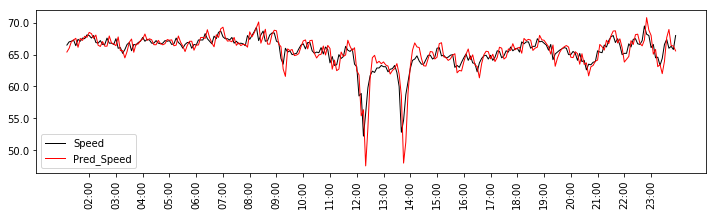

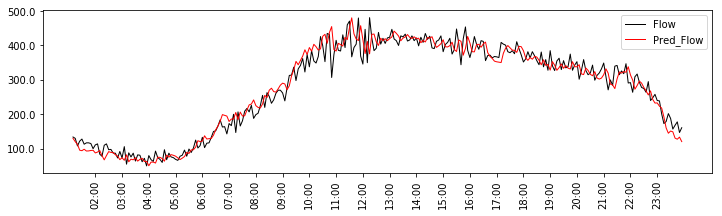

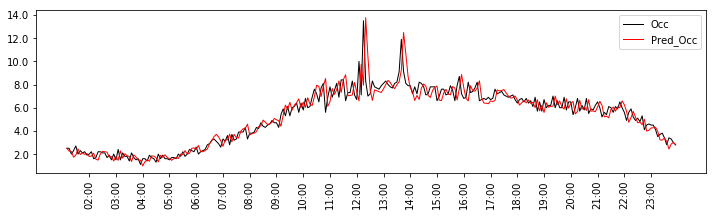

In [131]:
# randomly sample a base idx
rdn_idx = 274 * np.random.choice(int(X_test.shape[0] / 274))
rdn_end_idx = rdn_idx + 274
plot_time_series(X_test[rdn_idx:rdn_end_idx, 0], X_test[rdn_idx:rdn_end_idx, 3], 'Speed', 'Pred_Speed')
plot_time_series(X_test[rdn_idx:rdn_end_idx, 1], X_test[rdn_idx:rdn_end_idx, 4], 'Flow', 'Pred_Flow')
plot_time_series(X_test[rdn_idx:rdn_end_idx, 2], X_test[rdn_idx:rdn_end_idx, 5], 'Occ', 'Pred_Occ')